## CNNを用いた回帰モデルによる画像の高解像度化を行うよ
- ここでは，様々な人の顔の画像データに対して128 x 128 ピクセルの画像Aとされを　32 x 32に縮小した画像Bを用意する．
- この際に，画像Bを128 x 128のサイズに拡大した結果と画像Aの各ピクセル値の誤差をとり，これを小さくしていく学習を行う．


### データの準備
- 以下のサイトから画像を準備しました．
    - http://vis-www.cs.umass.edu/lfw/
        - ダウンロードリンク: http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
- これを頭文字がX・Y・Zで始まる人物の画像データをtestデータに，それ以外をtrainデータにしました．
- Linux or MacOSの方はカレントディレクトリにtrain, testディレクトリを用意していただけると以下のコマンドで移動できます.
    - `mv lfw-deepfunneled/[A - W]* train/`
    - `mv lfw-deepfunneled/[X-Z]* test/`

### Dateset と DataLoaderの準備

In [1]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset

class DownsizeImageFolder(ImageFolder):
    
    # デフォルト値を含むものは、最後にしないとおしかりを受ける
    def __init__(self, root, transform = None, large_size = 128, small_size = 32, **kwds):
        super().__init__(root, transform = transform, **kwds)
        self.large_resizer = transforms.Resize(large_size)
        self.small_resizer = transforms.Resize(small_size)

    def __getitem__(self, index):
        path, _ = self.imgs[index]
        img = self.loader(path)

        # 読み込んだ画像を128 x 128 pixel to 32 x 32 pixelにresize

        large_image = self.large_resizer(img)
        small_image = self.small_resizer(img)

        # その他の変換を適用させる
        if self.transform is not None:
            large_image = self.transform(large_image)
            small_image = self.transform(small_image)

        return small_image, large_image


In [2]:
train_data = DownsizeImageFolder(
    "./lfw-deepfunneled/train", transforms.ToTensor()
)

test_data = DownsizeImageFolder(
    "./lfw-deepfunneled/test", transforms.ToTensor()
)

batch_size = 32
# num_workers は自身のCPUのcore数を指定して下さい
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 4)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False, num_workers = 4)

In [10]:
len(train_data)

13071

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

# ネットワークの構築

class net(nn.Module):

    def __init__(self):

        super(net, self).__init__()

        # define the network's architecture
        self.conv1 = nn.Conv2d(3, 256, kernel_size = 4, stride = 2, padding = 1)
        self.batchnormal1 = nn.BatchNorm2d(256)
        self.conv2 = nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1)
        self.batchnormal2 = nn.BatchNorm2d(512)
        self.convtrans1 = nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1)
        self.batchnormal3 = nn.BatchNorm2d(256)
        self.convtrans2 = nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1)
        self.batchnormal4 = nn.BatchNorm2d(128)
        self.convtrans3 = nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1)
        self.batchnormal5 = nn.BatchNorm2d(64)
        self.convtrans4 = nn.ConvTranspose2d(64, 3, kernel_size = 4, stride = 2, padding = 1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.batchnormal1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.batchnormal2(x)
        x = self.convtrans1(x)
        x = F.relu(x)
        x = self.batchnormal3(x)
        x = self.convtrans2(x)
        x = F.relu(x)
        x = self.batchnormal4(x)
        x = self.convtrans3(x)
        x = F.relu(x)
        x = self.batchnormal5(x)
        output = self.convtrans4(x)
        return output


In [5]:
import trainer

In [6]:
train_loss, test_loss = trainer.trainer(model, train_loader, test_loader, epoch_num = 20)

We use cuda:0
epoch1/20


100%|██████████| 409/409 [00:10<00:00, 39.85it/s]


1回目のepochでの訓練Loss: 0.026328049571660954 検証Loss: 0.005281273741275072
epoch2/20


100%|██████████| 409/409 [00:09<00:00, 41.17it/s]


2回目のepochでの訓練Loss: 0.004263460486421412 検証Loss: 0.003161841304972768
epoch3/20


100%|██████████| 409/409 [00:09<00:00, 41.05it/s]


3回目のepochでの訓練Loss: 0.0033731061423283915 検証Loss: 0.0025876082945615053
epoch4/20


100%|██████████| 409/409 [00:09<00:00, 41.10it/s]


4回目のepochでの訓練Loss: 0.0031131844191122026 検証Loss: 0.0024980115704238415
epoch5/20


100%|██████████| 409/409 [00:09<00:00, 41.21it/s]


5回目のepochでの訓練Loss: 0.0027463907122038177 検証Loss: 0.002601651009172201
epoch6/20


100%|██████████| 409/409 [00:09<00:00, 40.96it/s]


6回目のepochでの訓練Loss: 0.0026585609364052345 検証Loss: 0.0029753977432847023
epoch7/20


100%|██████████| 409/409 [00:09<00:00, 40.92it/s]


7回目のepochでの訓練Loss: 0.00250489837011837 検証Loss: 0.0030406592413783073
epoch8/20


100%|██████████| 409/409 [00:10<00:00, 40.85it/s]


8回目のepochでの訓練Loss: 0.0025063056027981247 検証Loss: 0.0019914289005100727
epoch9/20


100%|██████████| 409/409 [00:10<00:00, 40.86it/s]


9回目のepochでの訓練Loss: 0.0023306025824598366 検証Loss: 0.002378345001488924
epoch10/20


100%|██████████| 409/409 [00:10<00:00, 40.87it/s]


10回目のepochでの訓練Loss: 0.0024297856443964657 検証Loss: 0.0020281807519495487
epoch11/20


100%|██████████| 409/409 [00:10<00:00, 40.72it/s]


11回目のepochでの訓練Loss: 0.002261908883160586 検証Loss: 0.0032807195093482733
epoch12/20


100%|██████████| 409/409 [00:09<00:00, 40.98it/s]


12回目のepochでの訓練Loss: 0.002341826775106704 検証Loss: 0.002303888788446784
epoch13/20


100%|██████████| 409/409 [00:09<00:00, 40.94it/s]


13回目のepochでの訓練Loss: 0.002203116565715057 検証Loss: 0.0032868690323084593
epoch14/20


100%|██████████| 409/409 [00:10<00:00, 40.46it/s]


14回目のepochでの訓練Loss: 0.002142747966880047 検証Loss: 0.0018989642849192023
epoch15/20


100%|██████████| 409/409 [00:10<00:00, 40.77it/s]


15回目のepochでの訓練Loss: 0.002178865410888472 検証Loss: 0.0020390835124999285
epoch16/20


100%|██████████| 409/409 [00:10<00:00, 40.83it/s]


16回目のepochでの訓練Loss: 0.0020608800869835837 検証Loss: 0.001911570318043232
epoch17/20


100%|██████████| 409/409 [00:10<00:00, 40.88it/s]


17回目のepochでの訓練Loss: 0.002198396483151593 検証Loss: 0.00230066548101604
epoch18/20


100%|██████████| 409/409 [00:09<00:00, 40.91it/s]


18回目のepochでの訓練Loss: 0.0022484256244380673 検証Loss: 0.004749834071844816
epoch19/20


100%|██████████| 409/409 [00:10<00:00, 40.85it/s]


19回目のepochでの訓練Loss: 0.0024166548386111418 検証Loss: 0.0025771590881049633
epoch20/20


100%|██████████| 409/409 [00:10<00:00, 40.87it/s]


20回目のepochでの訓練Loss: 0.0021227132770959244 検証Loss: 0.0017973576905205846


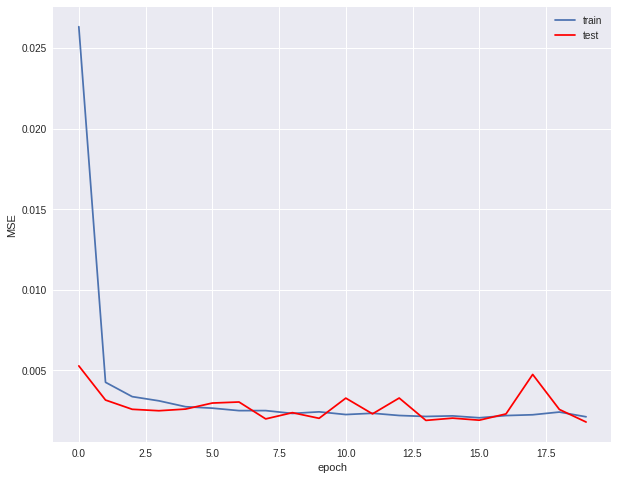

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")
%matplotlib inline

plt.figure(figsize = (10, 8))
plt.plot(train_loss, label = "train")
plt.plot(test_loss, label = "test", color = "red")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [8]:
from torchvision.utils import save_image
random_test_loader = DataLoader(test_data, batch_size = 5, shuffle=True)

# DataLoaderをイテレーターに変換して5つの例を取り出す

it = iter(random_test_loader)
small_image, large_image = next(it)


import torch 
import torch.nn as nn
import torch.nn.functional as F

# Bilinerで拡大したもの
bl_recon = F.upsample_bilinear(small_image, 128)

# CNNで拡大
cnn_image = model(small_image.to("cuda:0")).to("cpu")

/home/statistics3/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2622: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


In [9]:
save_image(torch.cat([large_image, bl_recon, cnn_image], dim = 0), "cnn_upsampling.jpg", nrow = 5)

In [12]:
save_image(small_image, "down_sampling.jpg")